In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import (named_colors, mpl_loc,
    fancy_legend, load_mpl_presets, append_axes, markers, append_axes)
import vice
import numpy as np
import math as m
import random
import sys
sys.path.append("..")
from src.utils import linear_exponential, exponential, chisquared
load_mpl_presets()
print(sys.version_info)

/var/home/johnson.7419.local/VICE/vice/__init__.py:138: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../data/wukong/wukong.dat")
data = vice.dataframe({})
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]
print(len(data["[fe/h]"]))

raw = np.genfromtxt("../data/wukong/wukong_expifr_102k4.out")
raw = np.array(list(filter(lambda _: not np.isinf(_[-1]), raw)))
raw = np.array(list(filter(lambda _: _[0] <= 100, raw)))
raw = np.array(list(filter(lambda _: _[-2] <= 6, raw)))
chain = vice.dataframe({})
chain["tau_in"] = raw[:, 0]
chain["eta"] = raw[:, 1]
chain["tau_star"] = raw[:, 2]
chain["tau_tot"] = raw[:, 3]
minlogp = min(raw[:, 4])
chain["logp"] = [_ - minlogp for _ in raw[:, 4]]
print(chain)

57
vice.dataframe{
    tau_in ---------> [66.4541, 7.35928, 2.81745, ... , 2.78618, 2.08743, 3.44114]
    eta ------------> [35.8195, 42.744, 54.5502, ... , 54.0377, 52.0808, 44.3725]
    tau_star -------> [48.0145, 49.454, 41.379, ... , 42.4426, 42.3663, 54.6515]
    tau_tot --------> [3.94908, 3.67484, 3.34251, ... , 3.35523, 2.98343, 3.51842]
    logp -----------> [8.034, 12.191, 14.094, ... , 14.543, 16.843, 14.314]
}


In [3]:
class gaussian:
    
    def __init__(self, mean = 0, width = 1):
        self.mean = mean
        self.width = width
        
    def __call__(self, x):
        return 1 / (self.width * np.sqrt(2 * np.pi)) * np.exp(
            -(x - self.mean)**2 / (2 * self.width**2)
        )
    
class lognormal:
    
    def __init__(self, mean = 0, width = 1):
        self.mean = mean
        self.width = width
        
    def __call__(self, x):
        return 1 / (x * self.width * np.sqrt(2 * np.pi)) * np.exp(
            -(np.log10(x) - np.log10(self.mean))**2 / (2 * self.width**2)
        )

def convolve(dist, bins, sigma, which = gaussian):
    new_dist = len(dist) * [0.]
    g = which(width = sigma)
    for i in range(len(new_dist)):
        g.mean = (bins[i] + bins[i + 1]) / 2
        for j in range(len(dist)):
            x = (bins[j] + bins[j + 1]) / 2
            new_dist[i] += dist[j] * g(x)
    norm = 0
    for i in range(len(dist)): norm += new_dist[i] * (bins[i + 1] - bins[i])
    new_dist = [_ / norm for _ in new_dist]
    return new_dist

9.120000000000008
2.5840000000000005


/var/home/johnson.7419.local/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


199


/home/johnson.7419/tmp/ipykernel_783/4110323096.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


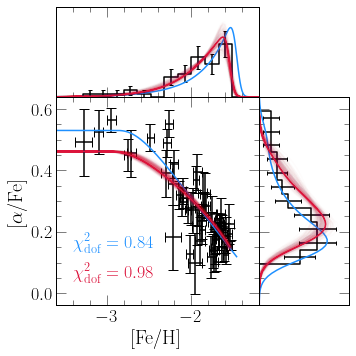

In [12]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-3.6, -1.2])
ax.set_ylim([-0.04, 0.64])

top = fig.add_axes([0.1, 0.9, 0.8, 0.2])
right = fig.add_axes([0.9, 0.1, 0.2, 0.8])
plt.setp(top.get_xticklabels(), visible = False)
plt.setp(top.get_yticklabels(), visible = False)
plt.setp(right.get_xticklabels(), visible = False)
plt.setp(right.get_yticklabels(), visible = False)
top.set_xlim(ax.get_xlim())
top.set_ylim([0, 3])
top.tick_params(axis = "y", which = "both", left = False, right = False)
right.set_xlim([0, 6])
right.set_ylim(ax.get_ylim())
right.tick_params(axis = "x", which = "both", bottom = False, top = False)

# med_feh_err = np.median(data["[fe/h]_err"])
# med_ofe_err = np.median(data["[o/fe]_err"])
# ax.scatter(data["[fe/h]"], data["[o/fe]"], c = named_colors()["black"], s = 20)
# ax.errorbar(-3, 0.2, xerr = med_feh_err, yerr = med_ofe_err, c = named_colors()["black"])
ax.errorbar(data["[fe/h]"], data["[o/fe]"], xerr = data["[fe/h]_err"], yerr = data["[o/fe]_err"],
    c = named_colors()["black"], linestyle = "None")

kwargs = {
    "bins": 15,
    "range": ax.get_xlim(),
#     "density": True
}
feh_counts, _ = np.histogram(data["[fe/h]"], density = False, **kwargs)
feh_dist, feh_bins = np.histogram(data["[fe/h]"], density = True, **kwargs)
idx = feh_counts.tolist().index(max(feh_counts))
norm = feh_counts[idx] / feh_dist[idx]
print(norm)
errors = [np.sqrt(_) / norm for _ in feh_counts]
top.step(feh_bins[:-1], feh_dist, where = "post", c = named_colors()["black"])
xvals = [(a + b) / 2 for a, b in zip(feh_bins[1:], feh_bins[:-1])]
top.errorbar(xvals, feh_dist, yerr = errors, c = named_colors()["black"], linestyle = "None", capsize = 2)

kwargs["range"] = ax.get_ylim()
afe_counts, _ = np.histogram(data["[o/fe]"], density = False, **kwargs)
afe_dist, afe_bins = np.histogram(data["[o/fe]"], density = True, **kwargs)
idx = afe_counts.tolist().index(max(afe_counts))
norm = afe_counts[idx] / afe_dist[idx]
print(norm)
errors = [np.sqrt(_) / norm for _ in afe_counts]
right.step(afe_dist, afe_bins[:-1], where = "pre", c = named_colors()["black"])
xvals = [(a + b) / 2 for a, b in zip(afe_bins[1:], afe_bins[:-1])]
right.errorbar(afe_dist, xvals, xerr = errors, c = named_colors()["black"], linestyle = "None", capsize = 2)

duration = 1.78
with vice.singlezone(name = "wukong_withyields") as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential(prefactor = 1000)
    sz.func.timescale = 74.98
    sz.mode = "ifr"
    sz.Mg0 = 0
    sz.eta = 14.01
    sz.tau_star = 29.78
    sz.dt = duration / 1000
    sz.bins = np.linspace(-5, 1, 601)
    vice.yields.ccsne.settings['o'] = 0.01
    vice.yields.sneia.settings['o'] = 0
    vice.yields.ccsne.settings['fe'] = 6.65e-4
    vice.yields.sneia.settings['fe'] = 3.26e-3
    yieldsout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)
    
ax.text(-3.4, 0.15, r"$\chi_\text{dof}^2 = 0.84$", fontsize = 18, c = named_colors()["dodgerblue"])
ax.plot(yieldsout.history["[fe/h]"], yieldsout.history["[o/fe]"], c = named_colors()["dodgerblue"])

duration = 3.36
with vice.singlezone(name = "wukong") as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential(prefactor = 1000)
    sz.func.timescale = 3.08
#     sz.func = lambda t: 1000
    sz.mode = "ifr"
    sz.Mg0 = 0
    sz.eta = 47.99
    sz.tau_star = 44.97
    sz.dt = duration / 1000
    sz.bins = np.linspace(-5, 1, 601)
    vice.yields.ccsne.settings['o'] = 0.01
    vice.yields.sneia.settings['o'] = 0
    vice.yields.ccsne.settings['fe'] = 7.78e-4
    vice.yields.sneia.settings['fe'] = 1.23e-3
    bfout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)
    
ax.text(-3.4, 0.05, r"$\chi_\text{dof}^2 = 0.98$", fontsize = 18, c = named_colors()["crimson"])
ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], c = named_colors()["crimson"])

med_feh_err = np.median(data["[fe/h]_err"])
med_ofe_err = np.median(data["[o/fe]_err"])

bins = yieldsout.mdf["bin_edge_left"] + [yieldsout.mdf["bin_edge_right"][-1]]
xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
feh_dist = convolve(yieldsout.mdf["dn/d[fe/h]"], bins, med_feh_err)
ofe_dist = convolve(yieldsout.mdf["dn/d[o/fe]"], bins, med_ofe_err)
top.plot(xvals, feh_dist, c = named_colors()["dodgerblue"])
right.plot(ofe_dist, xvals, c = named_colors()["dodgerblue"])

bins = bfout.mdf["bin_edge_left"] + [bfout.mdf["bin_edge_right"][-1]]
xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
feh_dist = convolve(bfout.mdf["dn/d[fe/h]"], bins, med_feh_err)
ofe_dist = convolve(bfout.mdf["dn/d[o/fe]"], bins, med_ofe_err)
top.plot(xvals, feh_dist, c = named_colors()["crimson"])
right.plot(ofe_dist, xvals, c = named_colors()["crimson"])

random.seed(a = 0)
n_subs = 200
prob = [m.exp(_) for _ in chain["logp"]]
norm = sum(prob)
prob = [_ / norm for _ in prob]
indeces = np.random.choice(list(range(len(prob))), p = prob, size = n_subs)
kwargs = {"c": named_colors()["crimson"]}

with vice.singlezone() as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential(prefactor = 1000)
    sz.mode = "ifr"
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.bins = np.linspace(-5, 1, 301)
    xvals = [(a + b) / 2 for a, b in zip(sz.bins[1:], sz.bins[:-1])]
    for i in range(n_subs):
        sz.name = "./wukong_subsamples/wukong%d" % (i)
        sz.func.timescale = chain["tau_in"][indeces[i]]
        sz.tau_star = chain["tau_star"][indeces[i]]
        sz.eta = chain["eta"][indeces[i]]
        sz.dt = chain["tau_tot"][indeces[i]] / 500
        out = sz.run(np.linspace(0, chain["tau_tot"][indeces[i]], 501), overwrite = True, capture = True)
        
        ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], alpha = 0.02, **kwargs)
        
        bins = out.mdf["bin_edge_left"] + [out.mdf["bin_edge_right"][-1]]
        xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
        feh_dist = convolve(out.mdf["dn/d[fe/h]"], bins, med_feh_err)
        ofe_dist = convolve(out.mdf["dn/d[o/fe]"], bins, med_ofe_err)

        top.plot(xvals, feh_dist, alpha = 0.01, **kwargs)
        right.plot(ofe_dist, xvals, alpha = 0.01, **kwargs)
        sys.stdout.write("\r%d" % (i))
    sys.stdout.write("\n")

plt.tight_layout()
plt.subplots_adjust(right = 0.73, top = 0.73)
top.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.25
])
right.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.25,
    ax.get_position().y1 - ax.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/wukong_bestfit.%s" % (ext), **kwargs)
plt.show()

In [6]:
cosmological_age = 13.2
quantities = list(filter(lambda _: not _.endswith("_err"), data.keys()))
# sub = vice.dataframe(mock.todict())
# sub["age"] = [m.log10(_) for _ in sub["age"]]
# sub["age_err"] = [0.1 if not m.isnan(_) else float("nan") for _ in sub["age"]]
sample = np.array([data[key] for key in quantities]).T
errors = np.array([data["%s_err" % (key)] for key in quantities]).T
model = len(bfout.history["time"]) * [None]
# model = len(yieldsout.history["time"]) * [None]
for i in range(len(model)):
    model[i] = len(quantities) * [0.]
    for j in range(len(quantities)):
        model[i][j] = bfout.history[quantities[j]][i]
#         model[i][j] = yieldsout.history[quantities[j]][i]
model = model[1:] # chop off the -inf [Fe/H] predicted at t = 0
weights = bfout.history["sfr"][1:]
# weights = yieldsout.history["sfr"][1:]
N = 0
for i in range(len(sample)):
    for j in range(len(sample[i])):
        if not m.isnan(sample[i][j]): N += 1
print(N)
chisq = chisquared(sample, errors, model, weights)
print(chisq / (N - 6))

114
0.9799642466997838


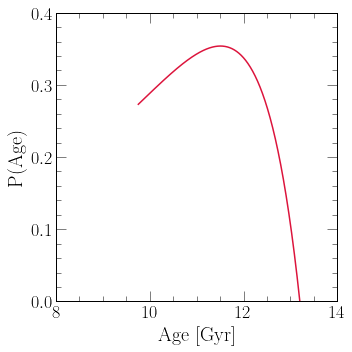

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("P(Age)")
ax.set_xlim([8, 14])
ax.set_ylim([0, 0.4])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])

xvals = [_ + 13.2 - bfout.history["time"][-1] for _ in bfout.history["lookback"]]
norm = sum(bfout.history["sfr"]) * (bfout.history["time"][1] - bfout.history["time"][0])
yvals = [_ / norm for _ in bfout.history["sfr"]]
ax.plot(xvals, yvals, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

199


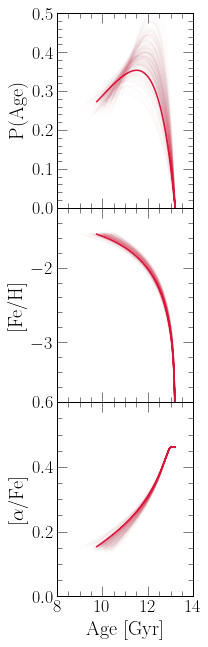

In [6]:
fig = plt.figure(figsize = (3, 9))
top = fig.add_subplot(311)
middle = fig.add_subplot(312)
bottom = fig.add_subplot(313)
for ax in [top, middle, bottom]:
    ax.set_xlim([8, 14])
    ax.set_xticks([8, 10, 12, 14])
#     ax.axvline(14, c = named_colors()["grey"], linestyle = "--")
plt.setp(top.get_xticklabels(which = "both"), visible = False)
plt.setp(middle.get_xticklabels(which = "both"), visible = False)
top.set_ylim([0, 0.5])
middle.set_ylim([-3.8, -1.2])
bottom.set_ylim([0, 0.6])
bottom.set_xlabel("Age [Gyr]")
bottom.set_ylabel(r"[$\alpha$/Fe]")
middle.set_ylabel("[Fe/H]")
top.set_ylabel("P(Age)")
    
with vice.output("./wukong") as bfout:
    diff = 13.2 - bfout.history["time"][-1]
    xvals = [_ + diff for _ in bfout.history["lookback"]]
    middle.plot(xvals, bfout.history["[fe/h]"], c = named_colors()["crimson"])
    bottom.plot(xvals, bfout.history["[o/fe]"], c = named_colors()["crimson"])
    xvals = [_ + 13.2 - bfout.history["time"][-1] for _ in bfout.history["lookback"]]
    norm = sum(bfout.history["sfr"]) * (bfout.history["time"][1] - bfout.history["time"][0])
    yvals = [_ / norm for _ in bfout.history["sfr"]]
    top.plot(xvals, yvals, c = named_colors()["crimson"])
    
random.seed(a = 0)
n_subs = 200
prob = [m.exp(_) for _ in chain["logp"]]
norm = sum(prob)
prob = [_ / norm for _ in prob]
indeces = np.random.choice(list(range(len(prob))), p = prob, size = n_subs)
kwargs = {
    "c": named_colors()["crimson"]
}

with vice.singlezone(name = "sampled") as sz:
    for i in range(n_subs):
        sz.elements = ["fe", "o"]
        sz.func = exponential(timescale = chain["tau_in"][indeces[i]])
        sz.func.timescale = chain["tau_in"][indeces[i]]
        sz.mode = "ifr"
        sz.Mg0 = 0
#         sz.nthreads = 2
        sz.tau_star = chain["tau_star"][indeces[i]]
        sz.eta = chain["eta"][indeces[i]]
        sz.dt = chain["tau_tot"][indeces[i]] / 500
#         vice.yields.ccsne.settings['fe'] = chain["y_fe_cc"][indeces[i]]
#         vice.yields.sneia.settings['fe'] = chain["y_fe_ia"][indeces[i]]
        out = sz.run(np.linspace(0, chain["tau_tot"][indeces[i]], 501),
            overwrite = True, capture = True)

        kwargs["alpha"] = 0.01
        diff = 13.2 - out.history["time"][-1]
        xvals = [_ + diff for _ in out.history["lookback"]]
        middle.plot(xvals, out.history["[fe/h]"], **kwargs)
        bottom.plot(xvals, out.history["[o/fe]"], **kwargs)
        xvals = [_ + 13.2 - out.history["time"][-1] for _ in out.history["lookback"]]
        norm = sum(out.history["sfr"]) * (out.history["time"][1] - out.history["time"][0])
        yvals = [_ / norm for _ in out.history["sfr"]]
        top.plot(xvals, yvals, **kwargs)

        sys.stdout.write("\r%d" % (i))
sys.stdout.write("\n")

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
# plt.subplots_adjust(hspace = 0, left = 0.2)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/wukong_agedist_amr.%s" % (ext), **kwargs)
plt.show()